In [1]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import FRUnet
from ImageLoader import ImageLoader2D

In [2]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "FRUnet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 150
min_loss_for_saving = 0.9

In [4]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 100


100it [00:11,  8.76it/s]


In [5]:
# Splitting the data, seed for reproducibility
seed_value = 42
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)
print(f"Using random seed {seed_value}")
print(f"Train Set Size {len(x_train)}")
print(f"Valid Set Size {len(x_valid)}")
print(f"Test Set Size {len(x_test)}")


Using random seed 42
Train Set Size 80
Valid Set Size 10
Test Set Size 10


In [6]:
# Defining the augmentations

aug__horizon_train = albu.Compose([
    albu.HorizontalFlip(),
])

aug__vertical_train = albu.Compose([
    albu.VerticalFlip(),
])

aug__color_train = albu.Compose([
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
])

aug__affine_train = albu.Compose([
    albu.Affine(),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        horizon = aug__horizon_train(image=x_train[i], mask=y_train[i])
        vertical = aug__vertical_train(image=x_train[i], mask=y_train[i])
        color = aug__color_train(image=x_train[i], mask=y_train[i])
        affine = aug__affine_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(horizon['image'])  
        y_train_out.append(horizon['mask'])
        x_train_out.append(vertical['image'])  
        y_train_out.append(vertical['mask'])
        x_train_out.append(color['image'])  
        y_train_out.append(color['mask'])
        x_train_out.append(affine['image'])  
        y_train_out.append(affine['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [7]:
# Creating the model

model = FRUnet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [8]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [9]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
80/80 [==============================] - 15s 118ms/step - loss: 0.5626 - val_loss: 0.8856
Loss Validation: 0.8824177
Loss Test: 0.9205537
Saved model with val_loss:  0.8824177


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 1
Learning Rate: 0.0001
80/80 [==============================] - 9s 114ms/step - loss: 0.3957 - val_loss: 0.9299
Loss Validation: 0.9334936
Loss Test: 0.9370495
Training, epoch 2
Learning Rate: 0.0001
80/80 [==============================] - 9s 114ms/step - loss: 0.3257 - val_loss: 0.7363
Loss Validation: 0.77581006
Loss Test: 0.6463853
Saved model with val_loss:  0.77581006


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 3
Learning Rate: 0.0001
80/80 [==============================] - 9s 113ms/step - loss: 0.2894 - val_loss: 0.4577
Loss Validation: 0.4674334
Loss Test: 0.48801613
Saved model with val_loss:  0.4674334


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 4
Learning Rate: 0.0001
80/80 [==============================] - 9s 109ms/step - loss: 0.2611 - val_loss: 0.4211
Loss Validation: 0.41724807
Loss Test: 0.43518096
Saved model with val_loss:  0.41724807


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 5
Learning Rate: 0.0001
80/80 [==============================] - 9s 109ms/step - loss: 0.2484 - val_loss: 0.5521
Loss Validation: 0.5405887
Loss Test: 0.42531192
Training, epoch 6
Learning Rate: 0.0001
80/80 [==============================] - 9s 108ms/step - loss: 0.2494 - val_loss: 0.3467
Loss Validation: 0.3295697
Loss Test: 0.34233028
Saved model with val_loss:  0.3295697


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 7
Learning Rate: 0.0001
80/80 [==============================] - 9s 109ms/step - loss: 0.2142 - val_loss: 0.3444
Loss Validation: 0.33006454
Loss Test: 0.2963205
Training, epoch 8
Learning Rate: 0.0001
80/80 [==============================] - 9s 116ms/step - loss: 0.2008 - val_loss: 0.3216
Loss Validation: 0.30638307
Loss Test: 0.30457538
Saved model with val_loss:  0.30638307


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 9
Learning Rate: 0.0001
80/80 [==============================] - 10s 121ms/step - loss: 0.1859 - val_loss: 0.3008
Loss Validation: 0.28801042
Loss Test: 0.26197428
Saved model with val_loss:  0.28801042


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 10
Learning Rate: 0.0001
80/80 [==============================] - 9s 108ms/step - loss: 0.1674 - val_loss: 0.3271
Loss Validation: 0.30710965
Loss Test: 0.34463042
Training, epoch 11
Learning Rate: 0.0001
80/80 [==============================] - 9s 107ms/step - loss: 0.1690 - val_loss: 0.3036
Loss Validation: 0.29445076
Loss Test: 0.23876065
Training, epoch 12
Learning Rate: 0.0001
80/80 [==============================] - 9s 107ms/step - loss: 0.1577 - val_loss: 0.3245
Loss Validation: 0.3302731
Loss Test: 0.29424906
Training, epoch 13
Learning Rate: 0.0001
80/80 [==============================] - 9s 108ms/step - loss: 0.1503 - val_loss: 0.3060
Loss Validation: 0.2915889
Loss Test: 0.27859902
Training, epoch 14
Learning Rate: 0.0001
80/80 [==============================] - 9s 109ms/step - loss: 0.1395 - val_loss: 0.3329
Loss Validation: 0.33667856
Loss Test: 0.27374953
Training, epoch 15
Learning Rate: 0.0001
80/80 [==============================] - 9s 114ms/step - loss

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 17
Learning Rate: 0.0001
80/80 [==============================] - 9s 118ms/step - loss: 0.1286 - val_loss: 0.2937
Loss Validation: 0.28207564
Loss Test: 0.28832436
Saved model with val_loss:  0.28207564


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 18
Learning Rate: 0.0001
80/80 [==============================] - 9s 115ms/step - loss: 0.1220 - val_loss: 0.3259
Loss Validation: 0.31379473
Loss Test: 0.39038062
Training, epoch 19
Learning Rate: 0.0001
80/80 [==============================] - 8s 104ms/step - loss: 0.1261 - val_loss: 0.3340
Loss Validation: 0.32151294
Loss Test: 0.33702713
Training, epoch 20
Learning Rate: 0.0001
80/80 [==============================] - 8s 101ms/step - loss: 0.1142 - val_loss: 0.3362
Loss Validation: 0.33278537
Loss Test: 0.31528574
Training, epoch 21
Learning Rate: 0.0001
80/80 [==============================] - 8s 101ms/step - loss: 0.1165 - val_loss: 0.4774
Loss Validation: 0.49566704
Loss Test: 0.465047
Training, epoch 22
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.1066 - val_loss: 0.3265
Loss Validation: 0.3184293
Loss Test: 0.31346542
Training, epoch 23
Learning Rate: 0.0001
80/80 [==============================] - 8s 103ms/step - loss: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 38
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0737 - val_loss: 0.3277
Loss Validation: 0.31537563
Loss Test: 0.33808678
Training, epoch 39
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0675 - val_loss: 0.3000
Loss Validation: 0.28421277
Loss Test: 0.27529013
Training, epoch 40
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0638 - val_loss: 0.2747
Loss Validation: 0.26915258
Loss Test: 0.26803023
Saved model with val_loss:  0.26915258


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 41
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0693 - val_loss: 0.2966
Loss Validation: 0.28332144
Loss Test: 0.26447415
Training, epoch 42
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0658 - val_loss: 0.3162
Loss Validation: 0.3033586
Loss Test: 0.25747305
Training, epoch 43
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0605 - val_loss: 0.2891
Loss Validation: 0.28570384
Loss Test: 0.24996209
Training, epoch 44
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0618 - val_loss: 0.3034
Loss Validation: 0.2876495
Loss Test: 0.2778092
Training, epoch 45
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0692 - val_loss: 0.3963
Loss Validation: 0.38273537
Loss Test: 0.44059843
Training, epoch 46
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.063

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 87
Learning Rate: 0.0001
80/80 [==============================] - 8s 100ms/step - loss: 0.0487 - val_loss: 0.2847
Loss Validation: 0.276492
Loss Test: 0.22645032
Training, epoch 88
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0402 - val_loss: 0.2885
Loss Validation: 0.2715729
Loss Test: 0.25219977
Training, epoch 89
Learning Rate: 0.0001
80/80 [==============================] - 8s 101ms/step - loss: 0.0449 - val_loss: 0.2863
Loss Validation: 0.27532077
Loss Test: 0.2556119
Training, epoch 90
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0322 - val_loss: 0.2729
Loss Validation: 0.26673388
Loss Test: 0.23354119
Training, epoch 91
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0431 - val_loss: 0.2870
Loss Validation: 0.2733751
Loss Test: 0.2698502
Training, epoch 92
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0374

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 93
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0414 - val_loss: 0.2716
Loss Validation: 0.26806867
Loss Test: 0.2453286
Training, epoch 94
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0357 - val_loss: 0.2895
Loss Validation: 0.27750236
Loss Test: 0.22961378
Training, epoch 95
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0420 - val_loss: 0.3315
Loss Validation: 0.3195315
Loss Test: 0.3503098
Training, epoch 96
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0441 - val_loss: 0.2847
Loss Validation: 0.2716133
Loss Test: 0.29482436
Training, epoch 97
Learning Rate: 0.0001
80/80 [==============================] - 7s 93ms/step - loss: 0.0375 - val_loss: 0.3009
Loss Validation: 0.29579622
Loss Test: 0.27545106
Training, epoch 98
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0409

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 100
Learning Rate: 0.0001
80/80 [==============================] - 8s 98ms/step - loss: 0.0363 - val_loss: 0.2809
Loss Validation: 0.2700864
Loss Test: 0.24056345
Training, epoch 101
Learning Rate: 0.0001
80/80 [==============================] - 8s 101ms/step - loss: 0.0346 - val_loss: 0.2714
Loss Validation: 0.25564086
Loss Test: 0.2225895
Saved model with val_loss:  0.25564086


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 102
Learning Rate: 0.0001
80/80 [==============================] - 8s 94ms/step - loss: 0.0343 - val_loss: 0.2944
Loss Validation: 0.28030777
Loss Test: 0.26134795
Training, epoch 103
Learning Rate: 0.0001
80/80 [==============================] - 8s 99ms/step - loss: 0.0384 - val_loss: 0.2793
Loss Validation: 0.26949114
Loss Test: 0.26244015
Training, epoch 104
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0442 - val_loss: 0.2801
Loss Validation: 0.26967424
Loss Test: 0.22686762
Training, epoch 105
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0367 - val_loss: 0.3069
Loss Validation: 0.29603142
Loss Test: 0.3186956
Training, epoch 106
Learning Rate: 0.0001
80/80 [==============================] - 8s 96ms/step - loss: 0.0340 - val_loss: 0.2772
Loss Validation: 0.26842004
Loss Test: 0.21117848
Training, epoch 107
Learning Rate: 0.0001
80/80 [==============================] - 8s 94ms/step - los

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 111
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0377 - val_loss: 0.2939
Loss Validation: 0.28788304
Loss Test: 0.23143911
Training, epoch 112
Learning Rate: 0.0001
80/80 [==============================] - 8s 94ms/step - loss: 0.0347 - val_loss: 0.2825
Loss Validation: 0.26760966
Loss Test: 0.25774974
Training, epoch 113
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0378 - val_loss: 0.3068
Loss Validation: 0.28621083
Loss Test: 0.34065855
Training, epoch 114
Learning Rate: 0.0001
80/80 [==============================] - 8s 106ms/step - loss: 0.0316 - val_loss: 0.2644
Loss Validation: 0.25352204
Loss Test: 0.25269252
Saved model with val_loss:  0.25352204


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 115
Learning Rate: 0.0001
80/80 [==============================] - 8s 104ms/step - loss: 0.0384 - val_loss: 0.2535
Loss Validation: 0.24691486
Loss Test: 0.24932575
Saved model with val_loss:  0.24691486


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 116
Learning Rate: 0.0001
80/80 [==============================] - 8s 104ms/step - loss: 0.0313 - val_loss: 0.3044
Loss Validation: 0.29448062
Loss Test: 0.31444412
Training, epoch 117
Learning Rate: 0.0001
80/80 [==============================] - 8s 105ms/step - loss: 0.0310 - val_loss: 0.2951
Loss Validation: 0.2908914
Loss Test: 0.25914836
Training, epoch 118
Learning Rate: 0.0001
80/80 [==============================] - 8s 105ms/step - loss: 0.0298 - val_loss: 0.2829
Loss Validation: 0.26682442
Loss Test: 0.270809
Training, epoch 119
Learning Rate: 0.0001
80/80 [==============================] - 8s 105ms/step - loss: 0.0351 - val_loss: 0.2593
Loss Validation: 0.24845129
Loss Test: 0.25351328
Training, epoch 120
Learning Rate: 0.0001
80/80 [==============================] - 8s 104ms/step - loss: 0.0372 - val_loss: 0.2722
Loss Validation: 0.26532286
Loss Test: 0.24096638
Training, epoch 121
Learning Rate: 0.0001
80/80 [==============================] - 9s 110ms/step -

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 126
Learning Rate: 0.0001
80/80 [==============================] - 8s 105ms/step - loss: 0.0343 - val_loss: 0.2837
Loss Validation: 0.28202122
Loss Test: 0.2184872
Training, epoch 127
Learning Rate: 0.0001
80/80 [==============================] - 9s 108ms/step - loss: 0.0289 - val_loss: 0.2774
Loss Validation: 0.26823348
Loss Test: 0.19437236
Training, epoch 128
Learning Rate: 0.0001
80/80 [==============================] - 8s 105ms/step - loss: 0.0342 - val_loss: 0.3106
Loss Validation: 0.29511023
Loss Test: 0.26411533
Training, epoch 129
Learning Rate: 0.0001
80/80 [==============================] - 8s 104ms/step - loss: 0.0327 - val_loss: 0.2709
Loss Validation: 0.26509213
Loss Test: 0.21927649
Training, epoch 130
Learning Rate: 0.0001
80/80 [==============================] - 9s 107ms/step - loss: 0.0315 - val_loss: 0.2760
Loss Validation: 0.26737416
Loss Test: 0.23411202
Training, epoch 131
Learning Rate: 0.0001
80/80 [==============================] - 9s 106ms/step

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/FRUnet_filters_17_2024_3_31_18_53_46\assets


Training, epoch 145
Learning Rate: 0.0001
80/80 [==============================] - 8s 94ms/step - loss: 0.0369 - val_loss: 0.2856
Loss Validation: 0.2758609
Loss Test: 0.2766931
Training, epoch 146
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0316 - val_loss: 0.2545
Loss Validation: 0.24698532
Loss Test: 0.23463249
Training, epoch 147
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0269 - val_loss: 0.2816
Loss Validation: 0.2712475
Loss Test: 0.24616098
Training, epoch 148
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0268 - val_loss: 0.2704
Loss Validation: 0.2638228
Loss Test: 0.23226494
Training, epoch 149
Learning Rate: 0.0001
80/80 [==============================] - 8s 97ms/step - loss: 0.0289 - val_loss: 0.3006
Loss Validation: 0.28325456
Loss Test: 0.26000822


Loading the model


3/3 [==============================] - 0s 25ms/step
results_FRUnet_17_kvasir.txt


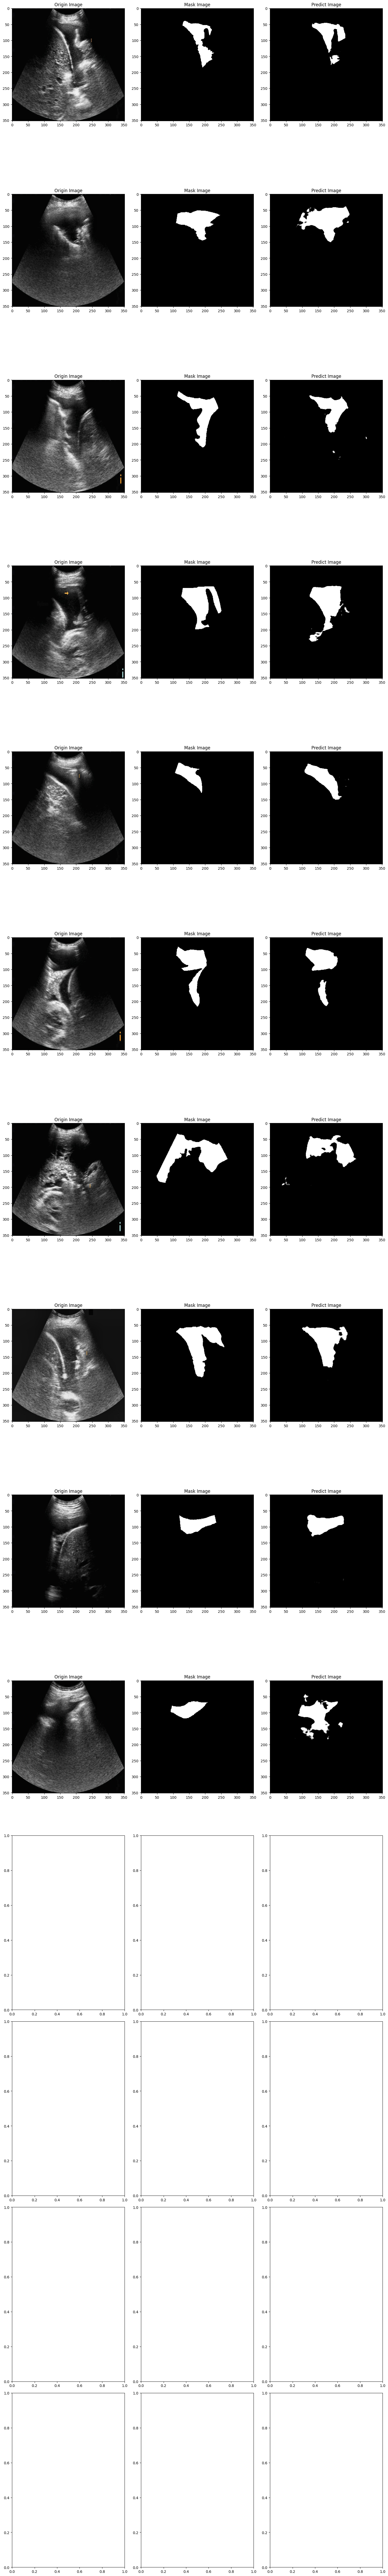

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
File done


In [10]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(14, 3, figsize=(15, 100))

final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')
    
     # 計算個別數值
    dice_value = f1_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                         np.ndarray.flatten(prediction_test[i] > 0.5))
    miou_value = jaccard_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                              np.ndarray.flatten(prediction_test[i] > 0.5))
    precision_value = precision_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                      np.ndarray.flatten(prediction_test[i] > 0.5))
    recall_value = recall_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                np.ndarray.flatten(prediction_test[i] > 0.5))
    accuracy_value = accuracy_score(np.ndarray.flatten(np.array(y_test[i], dtype=bool)),
                                    np.ndarray.flatten(prediction_test[i] > 0.5))

    with open(final_file, 'a') as f:
        f.write(f'Metrics for sample {i + 1}:\n')
        f.write(f'Dice: {dice_value}\n')
        f.write(f'MIOU: {miou_value}\n')
        f.write(f'Precision: {precision_value}\n')
        f.write(f'Recall: {recall_value}\n')
        f.write(f'Accuracy: {accuracy_value}\n')
        f.write('\n')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')